Classes: verbal arguments, road accidents, robbery, fighting, shootings, theft, vandalism, riots, stampedes, and normal behaviour

LSTM input: `(frame_num, is_anomaly, track_id, x_min, y_min, x_max, y_max, confidence, class)`

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

***Note:**

`batch_size`: Number of videos in a batch

`seq_length`: Number of frames in a video

`input_size`: 9

`hidden_size`: Dimensions of hidden state (let's start w/ 128)

In [3]:
# @title Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Making helper file

import os
import csv

l = sorted(os.listdir("/content/drive/MyDrive/anomaly_detection/Inputs"))
csv_file_name = "/content/drive/MyDrive/anomaly_detection/Inputs/files.csv"

fields = ['file_name']
inputs = [[f] for f in l if f != 'files.csv']

with open(csv_file_name, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(inputs)

with open(csv_file_name, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)

In [4]:
# @title Making the dataset

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class AnomalyDataset(Dataset):
    def __init__(self, file_list, inp_dir):
        self.files = pd.read_csv(file_list)
        self.inp_dir = inp_dir


    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError
        file_name = self.files['file_name'].iloc[idx]
        features_label = pd.read_csv(self.inp_dir + file_name)
        features = torch.Tensor(features_label[['frame_num', 'track_id', 'x_min', 'y_min', 'x_max', 'y_max', 'object_class']].values)
        label = torch.Tensor(features_label[['anomaly_in_frame']].values)

        return features, label


In [5]:
anomaly_map = {'Abuse':0,
               'Arrest':1,
               'Assault':2,
               'Burglary':3,
               'Fighting':4,
               'Normal':5,
               'RoadAccidents':6,
               'Shooting':7,
               'Shoplifting':8,
               'Vandalism':9}

In [ ]:
import re

def extract_train_anomaly_type(filename):
  """
  Extracts the anomaly type from a filename.

  Args:
    filename: The filename to extract the anomaly type from.

  Returns:
    The anomaly type, or None if not found.
  """
  filename = filename[6:]
  match = re.search(r'^(\D+)', filename)
  if match:
    anomaly_type = match.group(1)
    if anomaly_type == 'Normal_Videos_':
      return anomaly_map['Normal']
    else:
      return anomaly_map[anomaly_type]
  else:
    return None

filename = 'input_Normal_Videos_910_x264.mp4'
anomaly_type = extract_train_anomaly_type(filename)
print(anomaly_type)

5


In [26]:
import re

def extract_test_anomaly_type(filename):
  """
  Extracts the anomaly type from a filename.

  Args:
    filename: The filename to extract the anomaly type from.

  Returns:
    The anomaly type, or None if not found.
  """
  filename = filename[5:]
  match = re.search(r'^(\D+)', filename)
  if match:
    anomaly_type = match.group(1)
    if anomaly_type == 'Normal_Videos_':
      return anomaly_map['Normal']
    else:
      return anomaly_map[anomaly_type]
  else:
    return None

# filename = 'test_Normal_Videos_910_x264.mp4'
# anomaly_type = extract_test_anomaly_type(filename)
# print(anomaly_type)

In [7]:
# @title Making the test dataset

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class AnomalyTestDataset(Dataset):
    def __init__(self, file_list, inp_dir):
        self.files = pd.read_csv(file_list)
        self.inp_dir = inp_dir


    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError
        file_name = self.files['file_name'].iloc[idx] # <- use this to get anomaly_in_video from file name string
        features_label = pd.read_csv(self.inp_dir + file_name)
        features = torch.Tensor(features_label[['frame_num', 'track_id', 'x_min', 'y_min', 'x_max', 'y_max', 'object_class']].values)
        # label = torch.Tensor(features_label[['anomaly_in_frame']].values)

        # Return anomaly class (from file name)
        anomaly_class = torch.tensor(extract_test_anomaly_type(file_name)) # make it a tensor?

        return features, anomaly_class

In [8]:
# @title Defining the model

from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.functional import softmax

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, batch_size):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # # x: (n, 28, 28), h0: (2, n, 128)
        # # Change x from PackedSequence to Tensor of correct dims
        # x = unpack_sequence(x, batch_first=True)

        # x is a variable length PackedSequence
        # Forward propagate LSTM
        out, (h0, c0) = self.lstm(x, (h0, c0))
        out, out_lengths = pad_packed_sequence(out, batch_first=True)

        # out: tensor of shape (batch_size, padded_seq_length, hidden_size)
        # # out: (n, 28, 128)
        # out: padded Tensor

        # Decode the hidden state of the last time step
        # out = out[:, -1, :]

        out = self.fc(out)
        # out = softmax(out, dim=2)
        # out: (n, 10)
        # Select one predicted class from predicted probabilities?
        return out

In [9]:
# @title Initialising the model
input_size = 7
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 10

model = LSTM(input_size, hidden_size, num_layers, num_classes, batch_size).to(device)

In [10]:
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot

def my_collate(batch):
    # batch contains a list of tuples of structure (sequence, target)
    data = [item[0] for item in batch]
    data = pack_sequence(data, enforce_sorted=False)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=True)
    # targets: (batch_size, seq_len, 1)
    targets = torch.squeeze(targets)
    targets = targets.long()

    # # Next, one_hot encode!
    # targets = one_hot(targets, num_classes=10)
    # targets: (batch_size, seq_len, 1)
    # print("!", (targets[0]))
    # print("!!", type(targets))
    # targets = torch.stack(targets)
    # print("!!!", targets.shape)
    # print("!!!!", type(targets))
    # targets = pack_sequence(targets, enforce_sorted=False)

    # i want targets: tensor(batch_size, seq_len, 1)
    return [data, targets]

In [11]:
from torch.utils.data import DataLoader

torch.manual_seed(42)

epoch_count = []
train_loss_values = [0 for i in range(10)]
# test_loss_values = []

# Hyper-parameters
# input_size = 784 # 28x28
num_classes = 10
num_epochs = 10
batch_size = 10
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2

# # MNIST dataset
# train_dataset = torchvision.datasets.MNIST(root='./data',
#                                            train=True,
#                                            transform=transforms.ToTensor(),
#                                            download=True)

# test_dataset = torchvision.datasets.MNIST(root='./data',
#                                           train=False,
#                                           transform=transforms.ToTensor())

train_dataset = AnomalyDataset('/content/drive/MyDrive/anomaly_detection/Inputs/files.csv', '/content/drive/MyDrive/anomaly_detection/Inputs/')

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=my_collate,
                                           shuffle=True)
# print(train_loader)

# train_features, train_labels = next(iter(train_loader))
# print(type(train_labels))

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        # labels: (batch_size, seq_len): tensor
        labels = labels.to(device)

        # Forward pass
        outputs = model(features)
        # print(outputs.shape)
        # print(labels.shape)
        outputs = outputs.permute(0, 2, 1)
        # print(outputs.shape)
        # outputs: tensor (batch_size, seq_len, num_classes)
        # print(labels.shape)
        loss = criterion(outputs, labels) # how does features: (N, seq_len, num_features) correspond to labels: (N, num_classes)???
        # print(loss.shape)
        # loss = loss.sum()

        # Backward and optimize
        optimizer.zero_grad()
        loss.mean().backward(retain_graph=True)
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        train_loss_values[epoch] += loss.detach().cpu().numpy().item()
    epoch_count.append(epoch+1)

Epoch [1/10], Step [1/23], Loss: 2.2710
Epoch [1/10], Step [2/23], Loss: 2.2262
Epoch [1/10], Step [3/23], Loss: 2.1738
Epoch [1/10], Step [4/23], Loss: 2.1264
Epoch [1/10], Step [5/23], Loss: 2.1090
Epoch [1/10], Step [6/23], Loss: 2.0747
Epoch [1/10], Step [7/23], Loss: 1.9223
Epoch [1/10], Step [8/23], Loss: 1.7920
Epoch [1/10], Step [9/23], Loss: 1.8558
Epoch [1/10], Step [10/23], Loss: 1.5852
Epoch [1/10], Step [11/23], Loss: 1.6301
Epoch [1/10], Step [12/23], Loss: 1.6534
Epoch [1/10], Step [13/23], Loss: 1.8614
Epoch [1/10], Step [14/23], Loss: 1.9359
Epoch [1/10], Step [15/23], Loss: 1.6958
Epoch [1/10], Step [16/23], Loss: 1.8035
Epoch [1/10], Step [17/23], Loss: 1.5350
Epoch [1/10], Step [18/23], Loss: 1.8512
Epoch [1/10], Step [19/23], Loss: 1.8582
Epoch [1/10], Step [20/23], Loss: 1.7451
Epoch [1/10], Step [21/23], Loss: 1.0247
Epoch [1/10], Step [22/23], Loss: 1.5426
Epoch [1/10], Step [23/23], Loss: 1.4446
Epoch [2/10], Step [1/23], Loss: 1.8900
Epoch [2/10], Step [2/23],

In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/anomaly_detection/model_5.pth')

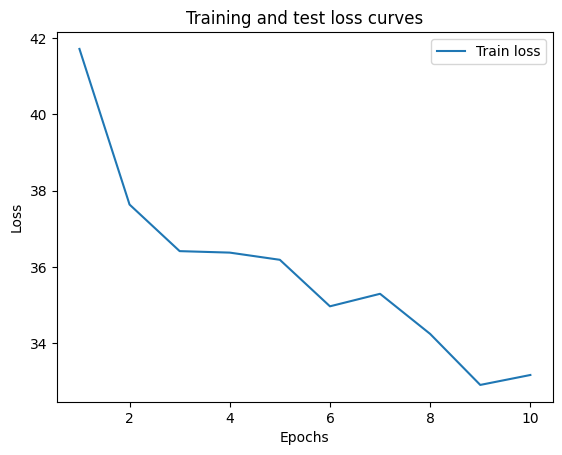

In [12]:
# @title Visualise loss curves

import matplotlib.pyplot as plt

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [19]:
# @title Load model

input_size = 7
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 10

model = LSTM(input_size, hidden_size, num_layers, num_classes, batch_size).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/anomaly_detection/model_5.pth'))

<All keys matched successfully>

In [13]:
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot

def test_collate(batch):
    # batch contains a list of tuples of structure (sequence, target)
    data = [item[0] for item in batch]
    data = pack_sequence(data, enforce_sorted=False)
    targets = [item[1] for item in batch]
    targets = torch.Tensor(targets)
    targets = targets.long()
    # targets = pad_sequence(targets, batch_first=True)
    # # targets: (batch_size, seq_len, 1)
    # targets: int (just the video's class)
    # targets = torch.squeeze(targets)
    # targets = targets.long()

    # # Next, one_hot encode!
    # targets = one_hot(targets, num_classes=10)
    # targets: (batch_size, seq_len, 1)
    # print("!", (targets[0]))
    # print("!!", type(targets))
    # targets = torch.stack(targets)
    # print("!!!", targets.shape)
    # print("!!!!", type(targets))
    # targets = pack_sequence(targets, enforce_sorted=False)

    # i want targets: tensor(batch_size, seq_len, 1)
    return [data, targets]

In [14]:
# @title Create DataLoader for test dataset

batch_size = 10

test_dataset = AnomalyTestDataset('/content/drive/MyDrive/anomaly_detection/Test/files.csv', '/content/drive/MyDrive/anomaly_detection/Test/')

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          collate_fn=test_collate,
                                          shuffle=False)

In [15]:
# @title Plot ROC Curve

import numpy as np

with torch.inference_mode():
    n_correct = 0
    n_samples = 0
    # y_true: np array of if an input (video) is anomalous (1) or not (0).
    # y_score: np array of how strongly the model thinks an input (video) is anomalous (1) or not (0).
    y_true = []
    y_score = []

    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        outputs = torch.softmax(outputs, dim=2)

        for input, output in zip(labels, outputs):
          normal = 0
          if input == 5:
            y_true.append(1)
          else:
            y_true.append(0)

          for frame in output:
            normal += frame[4].cpu().tolist()
          y_score.append(normal / outputs.size(1))

    print(y_true)
    print(y_score)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.08027350196554392, 0.05793633523850256, 0.061646352591179863, 0.08398420508842909, 0.08436705394582049, 0.08397657584249564, 0.008964696955554333, 0.07511277876884025, 0.08066363448110166, 0.08711011691431793, 0.08573267787934287, 0.0851372935706805, 0.07128302339871308, 0.0636309691692599, 0.04688405794098625, 0.0773648814198626, 0.008253399587605598, 0.034030268490738744, 0.027064187254472478, 0.0795874230218374, 0.06681677460363107, 0.07974841075135954, 0.008339810077823155, 0.07190531084784318, 0.08523756203042304, 0.08447514874147792, 0.08479693103104854, 0.08685996285745284, 0.08158929677101716, 0.08647920276867879, 0.06347904061571291, 0.06926204666153733, 0.008316742251207111, 0.07131140383213819, 0.035274550209747846, 0.02795996239120937, 0.02392747691308909, 0.04488208110402988, 0.08484630714334963, 0.07343872588192651, 0.08111113841

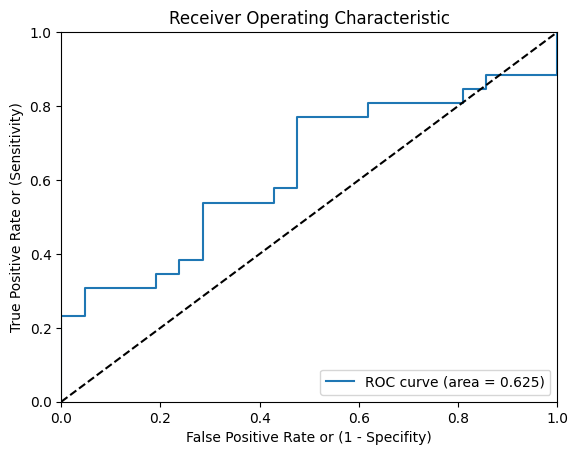

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [20]:
# @title Check test accuracy

# features, labels = next(iter(test_loader))
# # print(features.data.shape)
# labels

with torch.inference_mode():
    n_correct = 0
    n_samples = 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        outputs = torch.softmax(outputs, dim=2)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 2)
        predicted, _ = torch.mode(predicted)
        # print(predicted)
        # # print(outputs.shape == outputs.data.shape)
        # print(outputs.shape)
        # print(labels.shape)
        # break
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        # print(predicted)
        # print(labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test features: {acc} %')

Accuracy of the network on the test features: 14.893617021276595 %


In [25]:
# @title Create DataLoader for evaluating train dataset accuracy

batch_size = 10

test_dataset = AnomalyTestDataset('/content/drive/MyDrive/anomaly_detection/Inputs/files.csv', '/content/drive/MyDrive/anomaly_detection/Inputs/')

train_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          collate_fn=test_collate,
                                          shuffle=False)

In [24]:
# @title Check train accuracy

# features, labels = next(iter(test_loader))
# # print(features.data.shape)
# labels

with torch.inference_mode():
    n_correct = 0
    n_samples = 0
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        outputs = torch.softmax(outputs, dim=2)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 2)
        predicted, _ = torch.mode(predicted)
        # print(predicted)
        # # print(outputs.shape == outputs.data.shape)
        # print(outputs.shape)
        # print(labels.shape)
        # break
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        # print(predicted)
        # print(labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the train features: {acc} %')

Accuracy of the network on the train features: 17.48878923766816 %


## Miscellaneous

In [ ]:
# # train_dataset = AnomalyDataset('/content/drive/MyDrive/anomaly_detection/Inputs/files.csv', '/content/drive/MyDrive/anomaly_detection/Inputs/')
# # idx = 1
# # print(train_dataset.files['file_name'].iloc[idx])
# # f, l = train_dataset.__getitem__(0)
# # f

# from torch.nn.utils.rnn import pad_sequence

# df = pd.read_csv('/content/drive/MyDrive/anomaly_detection/Inputs/input_Normal_Videos_939_x264.mp4.csv')
# features = torch.Tensor(df[['frame_num', 'track_id', 'x_min', 'y_min', 'x_max', 'y_max', 'object_class']].values)
# features.shape

# # p = pad_sequence(features)
# # p.shape

torch.Size([7, 1178])

In [ ]:
# from torch.nn.functional import one_hot

# t = torch.tensor(5., dtype=torch.float)
# # t.type(torch.int)
# t = t.long()
# # one_hot(t, num_classes=10)
# t

tensor(5)

In [ ]:
# t = torch.Tensor([[[1, 2, 3], [4, 5, 6]],
#                   [[7, 8, 1], [10, 11, 12]]])
# _, pred = torch.max(t, 2)
# pred

tensor([[2, 2],
        [1, 2]])

In [ ]:
# import os

# l = os.listdir('/content/drive/MyDrive/anomaly_detection/Inputs')
# print(len(l))

# from collections import Counter

# d = Counter(l)
# # print(d)

# new_list = list([item for item in d if d[item]>1])
# # print(new_list)

# # for f in l:
# #   if f == 'input_Normal_Videos_417_x264.mp4.csv' or f == 'input_Normal_Videos_478_x264.mp4.csv':
# #     print(f)

# l = list(set(l))
# l = [[i] for i in l if i != 'Normal_Videos_935_x264.mp4' and i != 'files.csv']
# len(l)
# sorted(l)

In [ ]:
# import csv

# csv_file_name = '/content/drive/MyDrive/anomaly_detection/Inputs/files.csv'

# with open(csv_file_name, 'w') as csvfile:
#     # creating a csv writer object
#     csvwriter = csv.writer(csvfile)

#     csvwriter.writerow(['file_name'])

#     # writing the data rows
#     csvwriter.writerows(l)
# c=0
# with open(csv_file_name, mode ='r')as file:
#   csvFile = csv.reader(file)
#   for lines in csvFile:
#       if lines == 'Normal_Videos_935_x264.mp4':
#         print(lines)

In [ ]:
# import os
# done = os.listdir("/content/drive/MyDrive/anomaly_detection/Inputs")
# done = [d[6:-4] for d in done]

# with open('/content/drive/MyDrive/anomaly_detection/Temporal_Anomaly_Annotation_for_Testing_Videos.txt', 'r') as anno:
#   files = anno.readlines()
# for i in range(len(files)):
#   files[i] = files[i].split('  ')[0]

# to_do = []
# for f in files:
#   if f not in done and f[:13] == "Normal_Videos":
#     to_do.append(f)
# to_do

['Normal_Videos_935_x264.mp4']

In [ ]:
# import pandas as pd

# f = pd.read_csv('/content/drive/MyDrive/anomaly_detection/Inputs/input_Abuse028_x264.mp4.csv')
# f

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Hyper-parameters
# # input_size = 784 # 28x28
# num_classes = 10
# num_epochs = 2
# batch_size = 100
# learning_rate = 0.001

# input_size = 28
# sequence_length = 28
# hidden_size = 128
# num_layers = 2

# # MNIST dataset
# train_dataset = torchvision.datasets.MNIST(root='./data',
#                                            train=True,
#                                            transform=transforms.ToTensor(),
#                                            download=True)

# test_dataset = torchvision.datasets.MNIST(root='./data',
#                                           train=False,
#                                           transform=transforms.ToTensor())

# # Data loader
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=False)


# # Fully connected neural network with one hidden layer
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(RNN, self).__init__()
#         self.num_layers = num_layers
#         self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         # -> x needs to be: (batch_size, seq, input_size)

#         # or:
#         #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#         #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         # Set initial hidden states (and cell states for LSTM)
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

#         # x: (n, 28, 28), h0: (2, n, 128)

#         # Forward propagate RNN
#         out, _ = self.rnn(x, h0)
#         # or:
#         #out, _ = self.lstm(x, (h0,c0))

#         # out: tensor of shape (batch_size, seq_length, hidden_size)
#         # out: (n, 28, 128)

#         # Decode the hidden state of the last time step
#         out = out[:, -1, :]
#         # out: (n, 128)

#         out = self.fc(out)
#         # out: (n, 10)
#         return out

# model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# n_total_steps = len(train_loader)
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader):
#         # origin shape: [N, 1, 28, 28]
#         # resized: [N, 28, 28]
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# # Test the model
# # In test phase, we don't need to compute gradients (for memory efficiency)
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     for images, labels in test_loader:
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         # max returns (value ,index)
#         _, predicted = torch.max(outputs.data, 1)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels).sum().item()

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network on the 10000 test images: {acc} %')